In [2]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

In [4]:
test_dataset = KittiGraphDataset(basedir, "09", graph_length=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
checkpoint = torch.load(
    "./models/LOSS_TEST_B_VECTORIZED_BATCH1/model_40.pth", map_location=device
)

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [6]:
SELECTED_IDX = -1

predicted_poses = []
true_poses = []
shifts = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch).cpu().numpy()
        # get shift between last and second to last graph node
        last = output[-1]
        second_to_last = output[-2]
        shift = last - second_to_last
        shifts.append(shift)
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])
        predicted_poses.append(output[SELECTED_IDX])

100%|██████████| 1583/1583 [00:04<00:00, 385.34it/s]


In [7]:
print(shifts)

[array([ 3.8743019e-07, -2.2761524e-06, -1.6689301e-06,  4.1723251e-07,
        5.9604645e-08, -4.1723251e-07, -1.4901161e-07], dtype=float32), array([-2.6822090e-07,  2.8908253e-06,  2.2202730e-06, -5.3644180e-07,
       -5.9604645e-08,  5.3644180e-07,  1.4901161e-07], dtype=float32), array([-7.4505806e-07, -8.4750354e-07, -7.4505806e-07,  5.9604645e-08,
        5.9604645e-08,  0.0000000e+00, -8.9406967e-08], dtype=float32), array([ 2.9802322e-08, -4.7069043e-06, -3.0994415e-06,  5.9604645e-07,
        8.9406967e-08, -5.9604645e-07, -2.2351742e-07], dtype=float32), array([ 5.9604645e-08, -1.4342368e-07,  8.9406967e-08,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -1.4901161e-08], dtype=float32), array([-2.3841858e-07,  3.1813979e-06,  2.1904707e-06, -5.3644180e-07,
       -8.9406967e-08,  4.1723251e-07,  1.7881393e-07], dtype=float32), array([-6.5565109e-07,  1.5087426e-06,  8.9406967e-07, -2.3841858e-07,
       -2.9802322e-08,  2.3841858e-07,  4.4703484e-08], dtype=float32)

In [8]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]
    # rot = R.from_quat(rot)
    return {
        "position": pos,
        # "rotation": rot,
    }

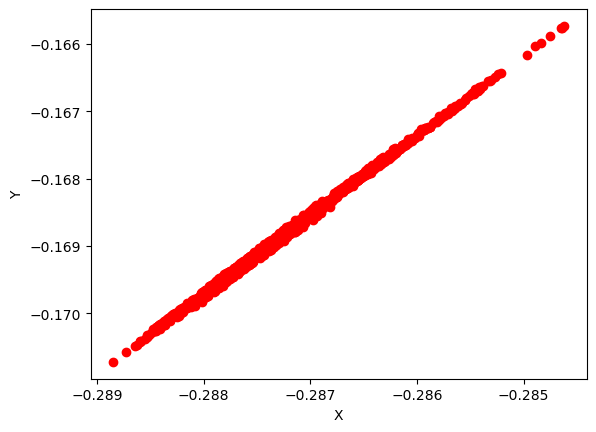

In [9]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

for pose in predicted_poses_e:
  ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

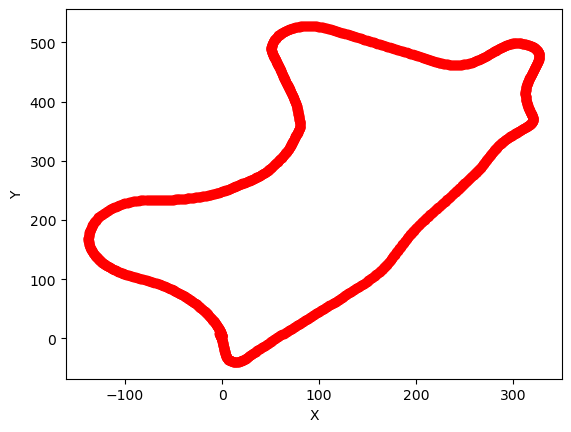

In [10]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

In [11]:
print(shifts[0])

[ 3.8743019e-07 -2.2761524e-06 -1.6689301e-06  4.1723251e-07
  5.9604645e-08 -4.1723251e-07 -1.4901161e-07]


In [12]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  predictions = [tensor_to_position_and_rotation(prediction) for prediction in predictions]
  world_positions = []
  world_rotations = []

  world_positions.append(predictions[0]["position"])

  for i, prediction in enumerate(predictions[1:]):
    world_positions.append(world_positions[i-1] + prediction["position"])
    print(f"Accumulated position: {world_positions[i-1]}")
    # now, rotations are in quaternion form so use appropriate function
    # world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [{"position": pos} for pos in world_positions]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

Accumulated position: [1.1920929e-07 6.1467290e-07 5.5134296e-07]
Accumulated position: [ 3.8743019e-07 -2.2761524e-06 -1.6689301e-06]
Accumulated position: [1.1920929e-07 6.1467290e-07 5.5134296e-07]
Accumulated position: [-3.5762787e-07 -3.1236559e-06 -2.4139881e-06]
Accumulated position: [ 1.4901161e-07 -4.0922314e-06 -2.5480986e-06]
Accumulated position: [-2.9802322e-07 -3.2670796e-06 -2.3245811e-06]
Accumulated position: [-8.9406967e-08 -9.1083348e-07 -3.5762787e-07]
Accumulated position: [-9.5367432e-07 -1.7583370e-06 -1.4305115e-06]
Accumulated position: [-4.7683716e-07  1.2796372e-06  9.2387199e-07]
Accumulated position: [-6.8545341e-07  1.6018748e-07  0.0000000e+00]
Accumulated position: [0.000000e+00 6.239861e-07 8.493662e-07]
Accumulated position: [-2.6822090e-07  1.4230609e-06  8.9406967e-07]
Accumulated position: [-3.2782555e-07 -1.3411045e-07  5.8114529e-07]
Accumulated position: [-8.0466270e-07 -1.7397106e-06 -1.2069941e-06]
Accumulated position: [ 0.0000000e+00 -3.57814

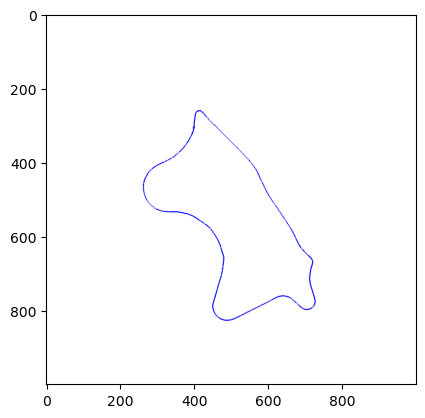

In [13]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

trajectory_image = np.zeros((1000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(shifts)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 400
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 400
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)
    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)


trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)

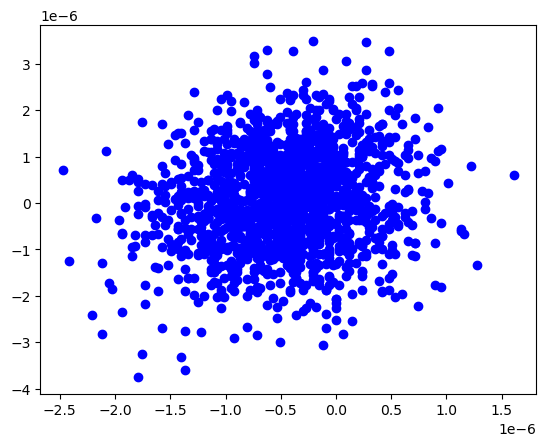

In [16]:
# draw a scatter plot of the trajectory
plt.scatter(
    [pose["position"][0] for pose in predicted_world_poses],
    [pose["position"][2] for pose in predicted_world_poses],
    c="b",
)